# Char-RNN in Pytorch: The Wisdom of Marx

Let's try to implement to implement [Andrej's minmal char-RNN](https://gist.github.com/karpathy/d4dee566867f8291f086) to generate text in Pytorch! The difference is that we'll use LSTM layers instead of vanilla RNN, and we'll do it in batches with GPU. 

Compared to the [Intermediate RNN tutorials on Pytorch's website](http://pytorch.org/tutorials/), the main difference is that this tutorial will take more advantage of the GPU, by taking in multiple words/characters at a time, and in batches.  

### Loading the Data
First we acquire the MS word version of [Das Kapital Volume 1](https://www.marxists.org/archive/marx/works/1867-c1/) and turned it into a text format that we can load. Let's see a snippet of it as well.  

In [1]:
raw_text = open('capital-vol1.txt', encoding='latin-1', mode='r').read()
raw_text[:1000]

'Chapter 1: Commodities\nSection 1: The Two Factors of a Commodity:\nUse-Value and Value\n(The Substance of Value and the Magnitude of Value)\nThe wealth of those societies in which the capitalist mode of production prevails, presents itself as \x93an immense accumulation of commodities,\x941 its unit being a single commodity. Our investigation must therefore begin with the analysis of a commodity. \nA commodity is, in the first place, an object outside us, a thing that by its properties satisfies human wants of some sort or another. The nature of such wants, whether, for instance, they spring from the stomach or from fancy, makes no difference.2 Neither are we here concerned to know how the object satisfies these wants, whether directly as means of subsistence, or indirectly as means of production. \nEvery useful thing, as iron, paper, &c., may be looked at from the two points of view of quality and quantity. It is an assemblage of many properties, and may therefore be of use in vario

Interesting! Let's print out all the characters in the text to see what we will be getting rid of.

In [2]:
chars = sorted(set(raw_text))
print('corpus has ' + str(len(raw_text)) + ' letters altogether')
print ('corpus has ' + str(len(chars)) + ' unique characters:', chars)

corpus has 1468303 letters altogether
corpus has 108 unique characters: ['\n', ' ', '!', '"', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '=', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', ']', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '{', '}', '\x91', '\x92', '\x93', '\x94', '\x96', '\xa0', '£', '°', '¼', '½', '¾', '×', 'à', 'â', 'æ', 'è', 'é', 'ê', 'î', 'ï', 'ô', 'û', 'ü']


First we'll clean up the text so that our output is limited to lower cased english characters plus simple punctuations. The cleaning function is taken from [stackoverflow](#https://stackoverflow.com/questions/517923/what-is-the-best-way-to-remove-accents-in-a-python-unicode-string).

In [3]:
import unicodedata
import string

all_letters = string.ascii_lowercase + " .,;'-"
n_letters = len(all_letters)

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

text = unicodeToAscii(raw_text)
text_length = len(text)
print('corpus has ' + str(text_length) + ' letters altogether')
print ('corpus has ' + str(len(set(text))) + ' unique characters after cleaning:', set(text))

corpus has 1427555 letters altogether
corpus has 32 unique characters after cleaning: {';', 'y', 'i', 'o', 's', 'g', 'd', 'z', 't', 'b', 'a', 'k', 'r', 'p', 'c', 'u', 'w', '-', 'f', 'n', 'q', 'm', 'e', 'l', 'v', ',', 'j', "'", '.', 'h', 'x', ' '}


Nice, though we can probably expect certain words with non-english characters to be misspelled. 

### Converting text to vectors

To create out dataset, we begin by creating a list of inputs and outputs. Our input should be a string of text, say 100 characters long (we will call this sequence length), and the output should be the next character following it. We can decide how many samples we want and how redundant they should be with the step size. The step size indicates how many characters we move ahead for every sample we create.

In [4]:
def textToWin(text, seq_len, step_size):
    inputs = []
    outputs = []
    for i in range(0, len(text) - seq_len, step_size):
        window = text[i:seq_len+i]
        inputs.append(window)
    outputs = [i for i in text[seq_len::step_size]]
    return inputs, outputs

inptest, outtest = textToWin('hello world', 5, 1)
print("sample size = ", len(inptest), inptest)
print("sample size = ", len(outtest), outtest)

sample size =  6 ['hello', 'ello ', 'llo w', 'lo wo', 'o wor', ' worl']
sample size =  6 [' ', 'w', 'o', 'r', 'l', 'd']


Next we incorporate the previous function and turn the outputted list of strings into tensors of indices (aka vectors), so that our model can process them. 

In [5]:
#setup idx and char mapping 
chars_to_idx = dict((c, i) for i, c in enumerate(all_letters))
idx_to_chars = dict((i, c) for i, c in enumerate(all_letters))

In [6]:
import torch

def textToTensor(text, seq_len, step_size):
    inputs, outputs = textToWin(text, seq_len, step_size)
    X = torch.zeros(len(inputs), seq_len).long()
    y = torch.zeros(len(inputs)).long()
    for i, seq in enumerate(inputs):
        for t, char in enumerate(seq):
            X[i, t] = chars_to_idx[seq[t]]
        y[i] = chars_to_idx[outputs[i]]
    # outputs X, y - (sample_size, seq_len), (sample_size) with value 0 < c < n_letters
    return X, y

test_text = "hello world"
testX, testy = textToTensor(test_text, 5, 2)
print(testX, testy)


  7   4  11  11  14
 11  11  14  26  22
 14  26  22  14  17
[torch.LongTensor of size 3x5]
 
 26
 14
 11
[torch.LongTensor of size 3]



We use the previous function to get the total sample size and split them into training set and valuation set. We roll the data set out in mini-batches by packing them into batch-sized generators.  We enumerate through the packed geneator to get X of (batch_size, seq_len) shape and y of (batch_size). Realize that taking the total sample size of the unpacked X and dividing that by the batch size gives us about the same number as the length of the packed X and y combine. It is slightly less because we tell it to drop the last batch if its size differs from the rest. 

In [66]:
import torch.utils.data
N = 512
W = 100
step_size=3

X, y = textToTensor(text, W, step_size)
sample_size = len(y)
train_size = int(0.9*sample_size)

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:], y[train_size:]

train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
val_dataset = torch.utils.data.TensorDataset(X_val, y_val)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=N, num_workers=1, pin_memory=True, drop_last=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=N, num_workers=1, pin_memory=True, drop_last=True)

print (len(X)/N)
print(len(train_loader) + len(val_loader))

929.333984375
928


### The Model 

In [67]:
import random
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

import time

# we will need to specifiy the variables as cuda to utilize GPU
cudafloat = torch.cuda.FloatTensor 
cudalong = torch.cuda.LongTensor

'''
W, H, N = seq_length, hidden_size, batch_size
'''

class LSTMText(nn.Module):
    def __init__(self, W, H, n_layers, N, dropout, num_embed=n_letters):
        super(LSTMText, self).__init__()
        self.num_embed = num_embed
        self.embed_dim = H
        self.H = H
        self.n_layers = n_layers
        self.W = W
        self.out_dim = num_embed
        self.N = N
        
        self.encoder = nn.Embedding(num_embed, self.embed_dim)
        self.lstm = nn.LSTM(self.embed_dim, H, n_layers, dropout=dropout)
        self.decoder = nn.Linear(H, self.out_dim)
        self.dropout = nn.Dropout(dropout)
        self.logsoftmax = nn.LogSoftmax()
        
    def init_hidden(self):
        h0 = Variable(torch.zeros(n_layers, N, H).type(cudafloat))
        c0 = Variable(torch.zeros(n_layers, N, H).type(cudafloat))
        return h0, c0
    
    def forward(self, inputs, hidden):                  
        embed = self.encoder(inputs)     # (N, W) => (N, W, embed_dim) 
        embed = embed.view(N, W, H)      # maintains 3D when N=1
        embed = embed.permute(1, 0, 2)   # (N, W, embed_dim) => (W, N, embed_dim)
        output, hidden = self.lstm(embed, hidden)   # (W, N, embed_dim) => (W, N, H)
        output = output[W-1, :, :]        # select  last vector of W (last character)
        decoded = self.decoder(output)              # (N, H) => (N, out_dim)
        pred = self.logsoftmax(decoded)
        
        return pred, hidden

This function disconnect the hidden cells from its history. We need this because we do not ned to backpropagate through the entire history of updates to the hidden cells. 
[source](https://discuss.pytorch.org/t/help-clarifying-repackage-hidden-in-word-language-model/226/2)

In [68]:
def repackage_hidden(h):
    """Wraps hidden states in new Variables, to detach them from their history."""
    """source: https://github.com/pytorch/examples/tree/master/word_language_model"""
    if type(h) == Variable:
        return Variable(h.data)
    else:
        return tuple(repackage_hidden(v) for v in h)

Next we instantiate the model and send it to the GPU with model.cuda(), and specify our update method and loss function. 

In [69]:
learning_rate = 1e-3
W = W
H = 500
n_layers = 2
dropout = 0.3

model = LSTMText(W=W, H=H, n_layers=n_layers, N=N, dropout=dropout)
model.cuda()
optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)
criterion = nn.NLLLoss(size_average=True)

Let's train! 

In [70]:
import matplotlib.pyplot as plt

graph_train, graph_val = [], []
best_val_loss = 100.0
n_epochs = 20
for epoch in range(n_epochs):
    start_time = time.time()
    train_loss, train_acc = 0.0, 0.0
    val_loss, val_acc = 0.0, 0.0
    hidden = model.init_hidden()
    
    # train
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # send input to GPU and wrap in torch Variable
        data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
             
        # forward, backward, optimize
        hidden = repackage_hidden(hidden)
        output, hidden = model(data, hidden)
        loss = criterion(output, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.data[0]/len(train_loader)
    
    
    # evaluate with validation set
    model.eval()
    for batch_idx, (data, target) in enumerate(val_loader):
        # send input to GPU and wrap in torch Variable
        data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target)
             
        # forward, backward, optimize
        hidden = repackage_hidden(hidden)
        output, hidden = model(data, hidden)
        loss = criterion(output, target)
       
        val_loss += loss.data[0]/len(val_loader)
    
    graph_train.append(train_loss)
    graph_val.append(val_loss)
    
    print('[%d] train loss: %.3f val loss: %.3f time: %.3f' % (epoch + 1, train_loss, val_loss, time.time() - start_time))
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_loss_weight') 
        print('saving least val loss model from epoch [%d]'% (epoch+1))

[1] train loss: 1.476 val loss: 1.460 time: 163.152
saving least val loss model from epoch [1]
[2] train loss: 1.212 val loss: 1.389 time: 165.259
saving least val loss model from epoch [2]
[3] train loss: 1.136 val loss: 1.351 time: 166.735
saving least val loss model from epoch [3]
[4] train loss: 1.086 val loss: 1.336 time: 167.744
saving least val loss model from epoch [4]
[5] train loss: 1.049 val loss: 1.328 time: 167.248
saving least val loss model from epoch [5]
[6] train loss: 1.017 val loss: 1.324 time: 167.107
saving least val loss model from epoch [6]
[7] train loss: 0.991 val loss: 1.324 time: 167.117
saving least val loss model from epoch [7]
[8] train loss: 0.967 val loss: 1.328 time: 167.026
[9] train loss: 0.946 val loss: 1.335 time: 166.811
[10] train loss: 0.928 val loss: 1.344 time: 167.257
[11] train loss: 0.911 val loss: 1.356 time: 166.953
[12] train loss: 0.894 val loss: 1.357 time: 167.223
[13] train loss: 0.879 val loss: 1.369 time: 167.178
[14] train loss: 0.

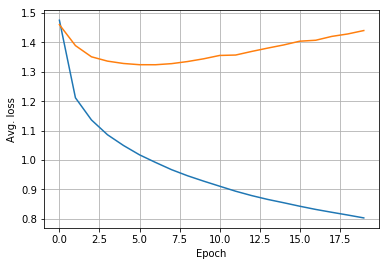

In [71]:
plt.ylabel('Avg. loss')
plt.xlabel('Epoch')
plt.plot(graph_train)
plt.plot(graph_val)
plt.grid(True)
plt.show()

In [72]:
torch.save(model.state_dict(), 'last_weight')

### Generating text
We create a new model with a batch_size of 1 to take in one sequence of text. 

In [77]:
import sys
N = 1

model_test = LSTMText(W=W, H=H, n_layers=n_layers, N=N, dropout=dropout)
model_test.cuda()
model_test.eval()
model_test.load_state_dict(torch.load('last_weight'))

In [78]:
def char_tensor(string):
    tensor = torch.zeros(len(string)).long().cuda()
    for c in range(len(string)):
        tensor[c] = chars_to_idx[string[c]]
    return Variable(tensor)

a = char_tensor('hello')
print (a)

Variable containing:
  7
  4
 11
 11
 14
[torch.cuda.LongTensor of size 5 (GPU 0)]



In [79]:
def pred_text(pred_len):
    start_index = random.randint(0, len(text) - W - 1)
    hidden = model_test.init_hidden()
    
    for temperature in [0.5, 0.8, 1.0]:
        print()
        print('----- temperature:', temperature)

        textX = text[start_index: start_index + W]
        print('----- Generating with seed: "' + textX + '"')
        inp = char_tensor(textX)
        inp = torch.unsqueeze(inp, 0)  # turn a [100] into [1, 100]
        
        for i in range(pred_len):
            # forward pass
            hidden = repackage_hidden(hidden)
            output, hidden = model_test(inp, hidden)
            
            # logsoftmax returns negative numbers. we undo that to sample from the array
            output_dist = output.view(-1).div(temperature).exp().cpu()
            top_i = torch.multinomial(output_dist, 1)[0]
            top_num = top_i.data[0]
            pred_char = idx_to_chars[top_num]
            
            # adds the new char to the text and remove the first char
            textX += pred_char
            textX = textX[1:]
            inp = char_tensor(textX)
            
            # print out the new char
            sys.stdout.write(pred_char)
            sys.stdout.flush()
        print()
        
pred_text(400)


----- temperature: 0.5
----- Generating with seed: "o its inmates. he exchange becomes an accomplished fact by two metamorphoses of opposite yet supplem"
ent. e were received that the compinitation of the most part weekly wages that the conditions of the industrial combinations of the workhouse had done fit for instance, and in the history of wages, and the dead with surplus population, that the former decreasing the present degree of the individual capitals suddenly means of production have been accumulated. he colliers will be invosible to the ab

----- temperature: 0.8
----- Generating with seed: "o its inmates. he exchange becomes an accomplished fact by two metamorphoses of opposite yet supplem"
ent to the soil as if the same time a million to the private labourers workshops, and for instance, but in the whole great part of the poorer line. uch additional manufacturers, man and partiarishes the direct and moral less character. o the parish, nay growned up the farmer, may have mad